# Imports

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import pandas as pd
import numpy as np
import gspread
import seaborn as sns
import numpy as np
import seaborn as sns
import calendar
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from gspread_formatting.dataframe import format_with_dataframe
from IPython.core.interactiveshell import InteractiveShell


plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 200

InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# gs-to-py-api@data-and-analitics-exel.iam.gserviceaccount.com
gc = gspread.service_account()

import snowflake.connector
import json
import os

snowflake_credentials_load_path = '~/credentials/snowflake_credentials.json'

# Expanding the user's home directory symbol (~)
full_path = os.path.expanduser(snowflake_credentials_load_path)

with open(full_path, 'r') as file:
    snowflake_credentials = json.load(file)
connection = snowflake.connector.connect(
    user = snowflake_credentials['user'],
    password = snowflake_credentials['password'],
    account = snowflake_credentials['account'],
    database = snowflake_credentials['database'],
    role = snowflake_credentials['role']
    )
cursor = connection.cursor()

# Data

## Load export

In [4]:
use_sample = False
reload_xlsx = False

data_folder = "../data/1-raw"


print("Using the following parameters:")
print("*" * 50)
print(f"Use sample: {use_sample}")
print(f"Reload xlsx: {reload_xlsx}")
print("*" * 50)

if reload_xlsx:
    # dict to match column names from excels
    match_columns = {
        "Datetime": "Datetime",
        "User_id": "User_id",
        "Round_id": "Bet Round_id",
        "Result": "Result",
        "Result.1": "Bet amount",
        "Reward": "Reward",
    }
    # Create a list of the new files
    new_files = [str(i) + ".xlsx" for i in range(1, 13)]
    new_files = [f"{data_folder}/reports/" + file for file in new_files]
    # Read each file and concatenate into a single dataframe
    combined_df = pd.concat([pd.read_excel(file) for file in new_files])

    # Reset the index of the combined dataframe
    combined_df = combined_df.reset_index(drop=True)
    combined_df = combined_df.rename(columns=match_columns)
    combined_df.to_pickle(f"{data_folder}/combined_df.pickle")
    combined_df.to_csv(f"{data_folder}/combined_df.csv", index=False)
    # Print the combined dataframe
    
print("Using sample data" if use_sample else "Using full data")
if use_sample:
    data = pd.read_csv(f"{data_folder}/__Reward.csv")
else:
    combined_df = pd.read_pickle(f"{data_folder}/combined_df.pickle")
    data = combined_df.copy(deep=True)
    data["Datetime"] = pd.to_datetime(data["Datetime"],format='mixed')

print("Preparing data for analysis:")

data["Datetime"] = pd.to_datetime(data["Datetime"])
print("Created: bet order")
data["bet_order"] = data.groupby("User_id")["Datetime"].rank(
    method="first", ascending=True
)
data = data.sort_values(by=["User_id", "bet_order"], ascending=True)

print("Created: first win")
data["first_win"] = np.where((data["Result"] == 1) & (data["bet_order"] == 1), 1, 0)
print("Created: bet after first win")
data["bet_after_first_win"] = np.where(
    (data["first_win"].shift() == 1) & (data["bet_order"] > 1), 1, 0
)
print("*" * 50)
data.head()
print("*" * 50)
print(f"Data shape: {data.shape}")
print("*" * 50)
print("Saving data")
data.to_csv("../data/data.csv", index=False)
print("*" * 50)
print("Unique users: ", data["User_id"].nunique())
print("-" * 50)
print("Date range: ", data["Datetime"].min(), data["Datetime"].max())

Using the following parameters:
**************************************************
Use sample: False
Reload xlsx: False
**************************************************
Using full data
Preparing data for analysis:
Created: bet order
Created: first win
Created: bet after first win
**************************************************


Datetime  User_id  \
17951  2023-01-28 08:05:00.839655       72   
29966  2023-01-28 08:06:17.145415       72   
13246  2023-01-28 08:06:42.512629       72   
32497  2023-01-28 08:07:10.071863       72   
264939 2023-07-07 22:23:36.001047       73   

                                Bet Round_id  Result  Bet amount  Reward  \
17951   7523b396-a8cf-4dbd-b617-d99375ffa356       1        0.42    0.64   
29966   c44eb259-8679-44b5-aa84-1455fcaa2856       1        0.42    0.64   
13246   55fb0b1a-4c0c-4794-b2f2-30d94672ddda       0        0.42    0.00   
32497   d5103d3e-ad2d-48e5-8142-8a8c9bc6a293       1        0.00    0.00   
264939  5659f3c3-5bfa-4037-a495-6344122b06c7       0        0.78    0.00   

        Casino  bet_order  first_win  bet_after_first_win  
17951   nomini        1.0          1                    0  
29966   nomini        2.0          0                    1  
13246   nomini        3.0          0                    0  
32497   nomini        4.0          0                    0  
264939  nomini        1.0          0                    0

**************************************************
Data shape: (505433, 10)
**************************************************
Saving data
**************************************************
Unique users:  90928
--------------------------------------------------
Date range:  2023-01-01 00:00:26.749803 2023-12-31 23:57:46.740333


In [177]:
print('Preparing data for analysis:')
bets = data.copy(deep=True)
bets.columns = bets.columns.str.replace(' ', '_')
bets.columns = [x.lower() for x in bets.columns]
bets['casino'] = bets['casino'].str.lower()
bets['datetime'] = pd.to_datetime(bets['datetime'],format='mixed')
bets['cw'] = bets['datetime'].dt.isocalendar().week
bets['month'] = bets['datetime'].dt.month
bets['year-month'] = bets['datetime'].dt.strftime('%Y-%m')
bets['day'] = bets['datetime'].dt.day
bets['date'] = bets['datetime'].dt.date
print('Bet data shape: ', bets.shape)

Preparing data for analysis:
Bet data shape:  (505433, 15)


## SQL

In [121]:
q = """
WITH crab_users AS (
    SELECT 
        cb.account_idt, 
        MIN(cb.date) AS first_time
    FROM DWH_DB.dwh.fact_casino_bets cb
    INNER JOIN DWH_DB.dwh.dim_game g
        ON g.game_idt = cb.game_idt
    WHERE game_name = 'Cash Crab'
    GROUP BY cb.account_idt
)
SELECT DISTINCT
    CAST(DATE_TRUNC('month', cb.date) AS DATE) AS month,
    cu.account_idt
FROM crab_users cu
INNER JOIN DWH_DB.dwh.fact_casino_bets cb
    ON cu.account_idt = cb.account_idt
    AND cu.first_time >= cb.date
INNER JOIN DWH_DB.dwh.dim_customers c
    ON c.account_idt = cu.account_idt
WHERE c.type IN ('casino', 'sport')
    AND YEAR(c.CREATED) = 2023
ORDER BY month, cu.account_idt;
"""
df_rentetion = pd.read_sql(q, connection)
df_rentetion.head()

/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_10699/1157307928.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rentetion = pd.read_sql(q, connection)


MONTH  ACCOUNT_IDT
0  2023-01-01      5383484
1  2023-01-01      5383502
2  2023-01-01      5383524
3  2023-01-01      5383769
4  2023-01-01      5383794

# EDA

In [178]:
dt = bets.groupby(['bet_order'], as_index=False).agg({
    'bet_round_id': 'nunique',
    'user_id':'nunique'
})
dt  = dt.rename(columns={'bet_round_id': 'bet_rounds', 'user_id': 'total_users'})
# dt = dt[dt['bet_order'] <= 10]
dt['share_of_users'] = dt['total_users']/dt['total_users'].max()
dt = dt[dt['bet_order'] <= 10]
dt['share_of_users'] = (dt['share_of_users']*100).astype(int)
dt['bet_order'] = dt['bet_order'].astype(int) 
dt.head()

bet_order  bet_rounds  total_users  share_of_users
0          1       90928        90928             100
1          2       55740        55740              61
2          3       36264        36264              39
3          4       28967        28967              31
4          5       22114        22114              24

In [256]:
ax = sns.barplot(x='bet_order', y='share_of_users', data=dt)
ax.set_title('Share of users by number of bets placed, %')
ax.set_xlabel('Bets placed')
ax.set_ylabel('Share of users, %')

# Add labels to the bar plots
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add a line plot on top of the bars
lineplot = sns.lineplot(x='bet_order', y='share_of_users', data=dt, color='red', marker='o')

plt.show()


Text(0.5, 1.0, 'Share of users by number of bets placed, %')

Text(0.5, 0, 'Bets placed')

Text(0, 0.5, 'Share of users, %')

Text(0, 5, '100.0%')

Text(0, 5, '61.0%')

Text(0, 5, '39.0%')

Text(0, 5, '31.0%')

Text(0, 5, '24.0%')

Text(0, 5, '20.0%')

Text(0, 5, '16.0%')

Text(0, 5, '14.0%')

Text(0, 5, '12.0%')

Text(0, 5, '10.0%')

In [257]:
first_bet = (
    bets[bets["bet_order"] == 1]
    .groupby(["user_id", "bet_order"])
    .agg(
        {
            "datetime": "min",
        }
    )
    .reset_index()
)
second_bet = (
    bets[bets["bet_order"] == 2]
    .groupby(["user_id", "bet_order"])
    .agg(
        {
            "datetime": "min",
        }
    )
    .reset_index()
)

bets_round_duration = first_bet.merge(second_bet, on="user_id", suffixes=("_1", "_2"), how="inner")
bets_round_duration["duration"] = bets_round_duration["datetime_2"] - bets_round_duration["datetime_1"]
bets_round_duration["minutes_between_rounds"] = bets_round_duration["duration"].dt.total_seconds() / 60



bins_edges = [
    0,
    0.5,
    1,
    2,
    3,
    5,
    10,
    30,
    60,
    24 * 60,
    np.inf,
]  # Adjusted bin edges for new intervals
bins_labels = [
    "< 30 sec",
    "30 - 60 sec",
    "1 - 2 min",
    "2 - 3 min",
    "3 - 5 min",
    "5 - 10 min",
    "10 - 30 min",
    "30 min - 1 hour",
    "1 hour - 1 day",
    "> 1 day",
]
bets_round_duration["bins_between_rounds"] = pd.cut(
    bets_round_duration["minutes_between_rounds"], bins=bins_edges, labels=bins_labels
)


dt_bets = bets_round_duration.groupby(["bins_between_rounds"]).agg(
    {
        "user_id": "nunique",
        "datetime_1": "min",
        "datetime_2": "max",
        "duration": "mean",
        "minutes_between_rounds": "mean",
    }
)
dt_bets = dt_bets.rename(columns={"user_id": "unique_users"})
dt_bets["share_of_users"] = (
    dt_bets["unique_users"] / dt_bets["unique_users"].sum() * 100
)
dt_bets["share_of_users"] = dt_bets["share_of_users"].astype(int)
dt_bets['cumulative_share'] = dt_bets['share_of_users'].cumsum()

fig = px.bar(
    dt_bets,
    x=dt_bets.index,
    y="share_of_users",
    title="Distribution of Time Between 1 and 2 Rounds (in Minutes) ", #of users who placed at least 2 bets
    labels={"share_of_users": "Share of Users (%)"},
    text="share_of_users",
)

# Customizing bar colors
fig = fig.update_traces(
    marker_color="RoyalBlue", texttemplate="%{text:f}%", textposition="outside"
)

# Enhancing layout
fig = fig.update_layout(
    plot_bgcolor="white",
    xaxis=dict(title="Time Between Rounds", linecolor="black", showgrid=False),
    yaxis=dict(title="Share of Users (%)", linecolor="black", showgrid=False),
    font=dict(size=12, color="black"),
    margin=dict(l=40, r=40, t=40, b=40),
)

# Show the graph
fig.show()

/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_10699/2086161697.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Text(0.5, 1.0, 'Distribution of Time Between 1 and 2 Rounds (in Minutes) ')

Text(0.5, 0, 'Time Between Rounds')

Text(0, 0.5, 'Share of Users (%)')

Text(0, 5, '28.0%')

Text(0, 5, '38.0%')

Text(0, 5, '13.0%')

Text(0, 5, '2.0%')

Text(0, 5, '1.0%')

Text(0, 5, '0.0%')

Text(0, 5, '0.0%')

Text(0, 5, '0.0%')

Text(0, 5, '1.0%')

Text(0, 5, '12.0%')

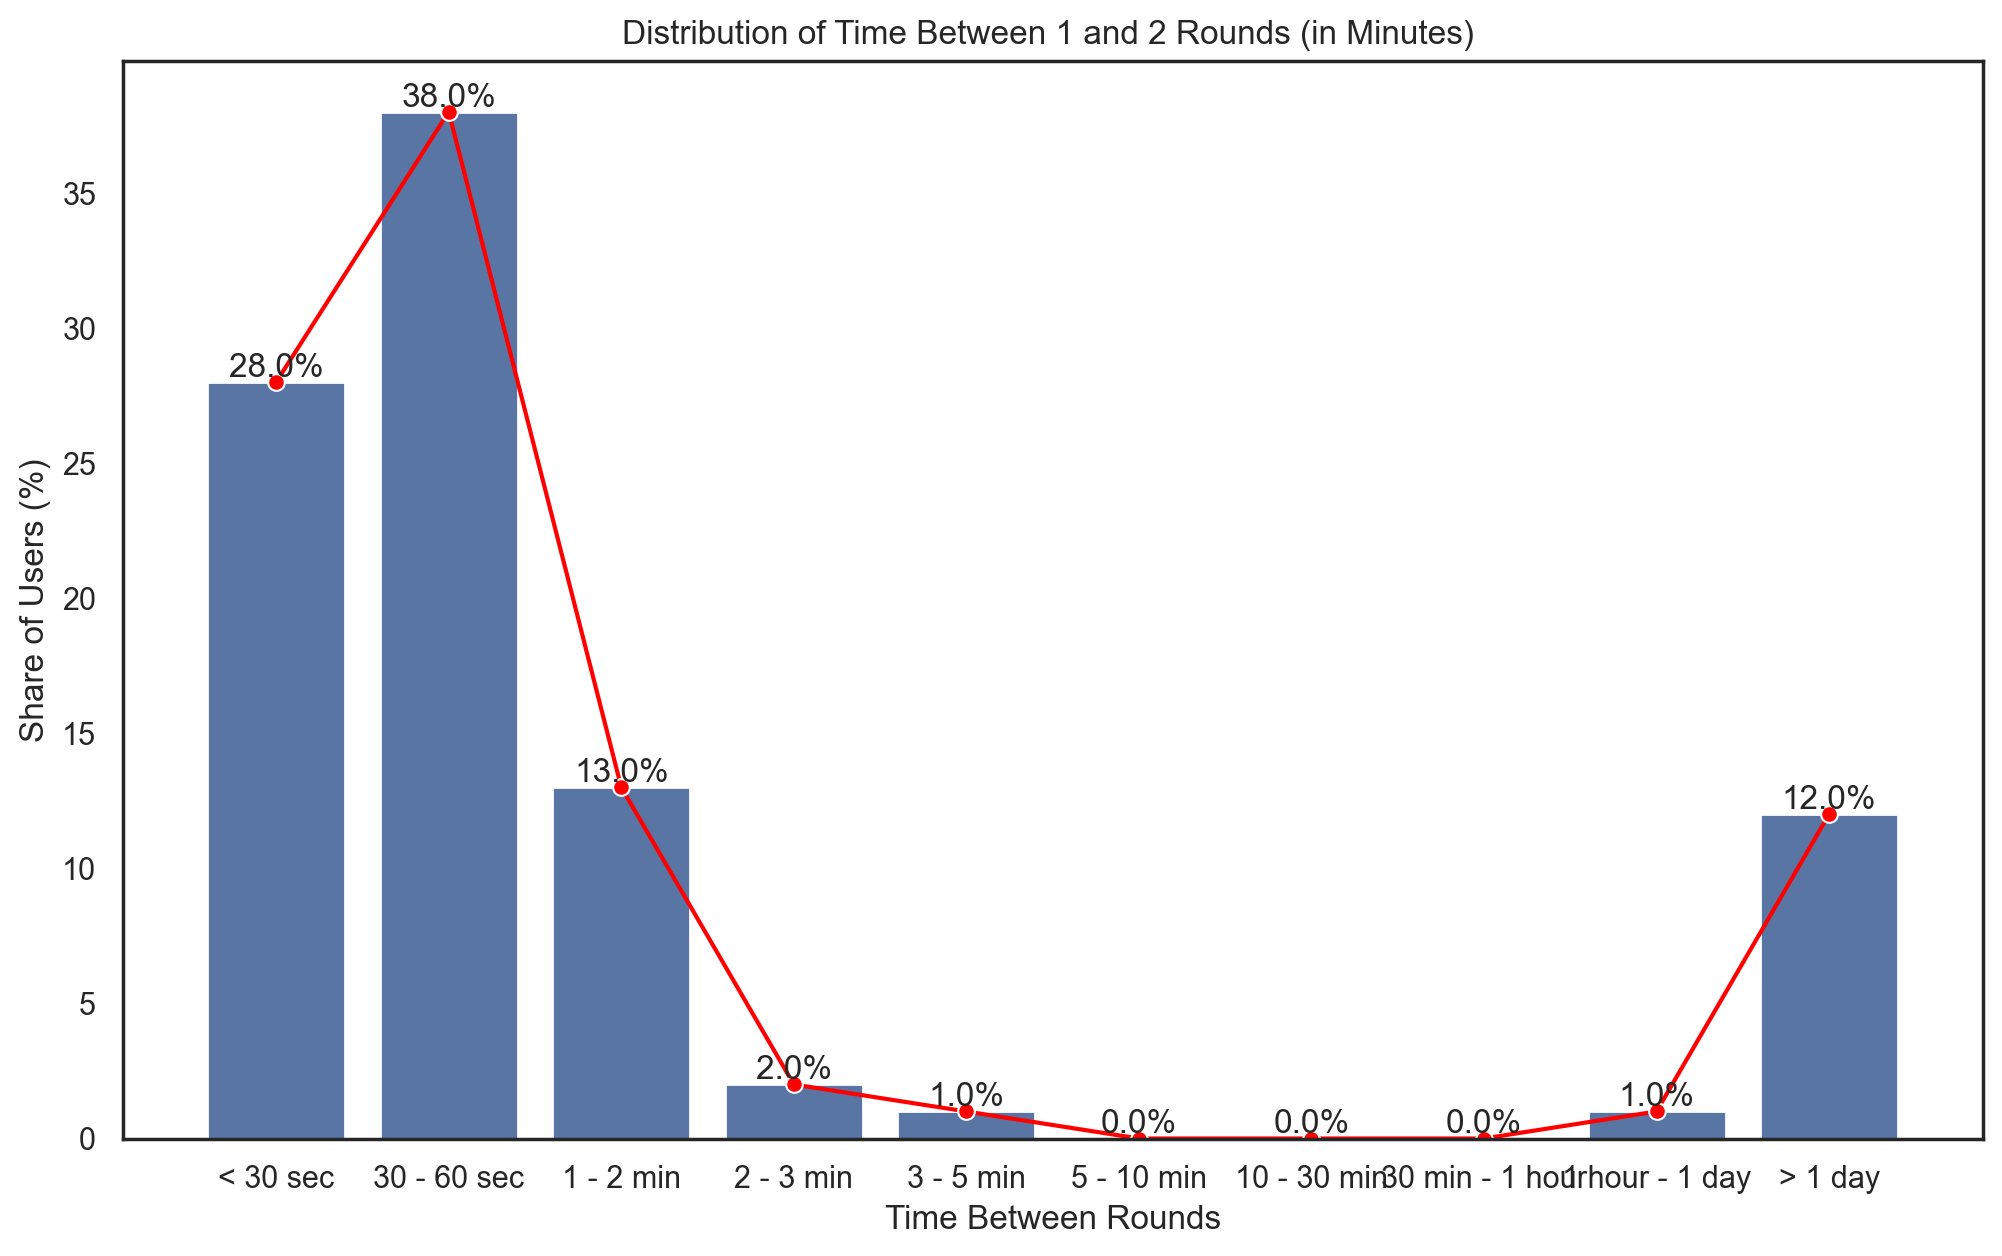

In [258]:
ax = sns.barplot(
    x=dt_bets.index,
    y="share_of_users",
    data=dt_bets
)
ax.set_title("Distribution of Time Between 1 and 2 Rounds (in Minutes) ")
ax.set_xlabel("Time Between Rounds")
ax.set_ylabel("Share of Users (%)")
# Add labels to the bar plots
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add a line plot on top of the bars
lineplot = sns.lineplot(x=dt_bets.index, y="share_of_users", data=dt_bets, color='red', marker='o')


Text(0.5, 1.0, '68% of users play the second round in quick succession (within 1 minute) ')

Text(0.5, 0, 'Time Between Rounds')

Text(0, 0.5, 'Cumulative Share of Users (%)')

/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_10699/409390987.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, '< 30 sec'),
 Text(1, 0, '30 - 60 sec'),
 Text(2, 0, '1 - 2 min'),
 Text(3, 0, '2 - 3 min'),
 Text(4, 0, '3 - 5 min'),
 Text(5, 0, '5 - 10 min'),
 Text(6, 0, '10 - 30 min'),
 Text(7, 0, '30 min - 1 hour'),
 Text(8, 0, '1 hour - 1 day'),
 Text(9, 0, '> 1 day')]

Text(0, 5, '28.0%')

Text(0, 5, '66.0%')

Text(0, 5, '79.0%')

Text(0, 5, '81.0%')

Text(0, 5, '82.0%')

Text(0, 5, '82.0%')

Text(0, 5, '82.0%')

Text(0, 5, '82.0%')

Text(0, 5, '83.0%')

Text(0, 5, '95.0%')

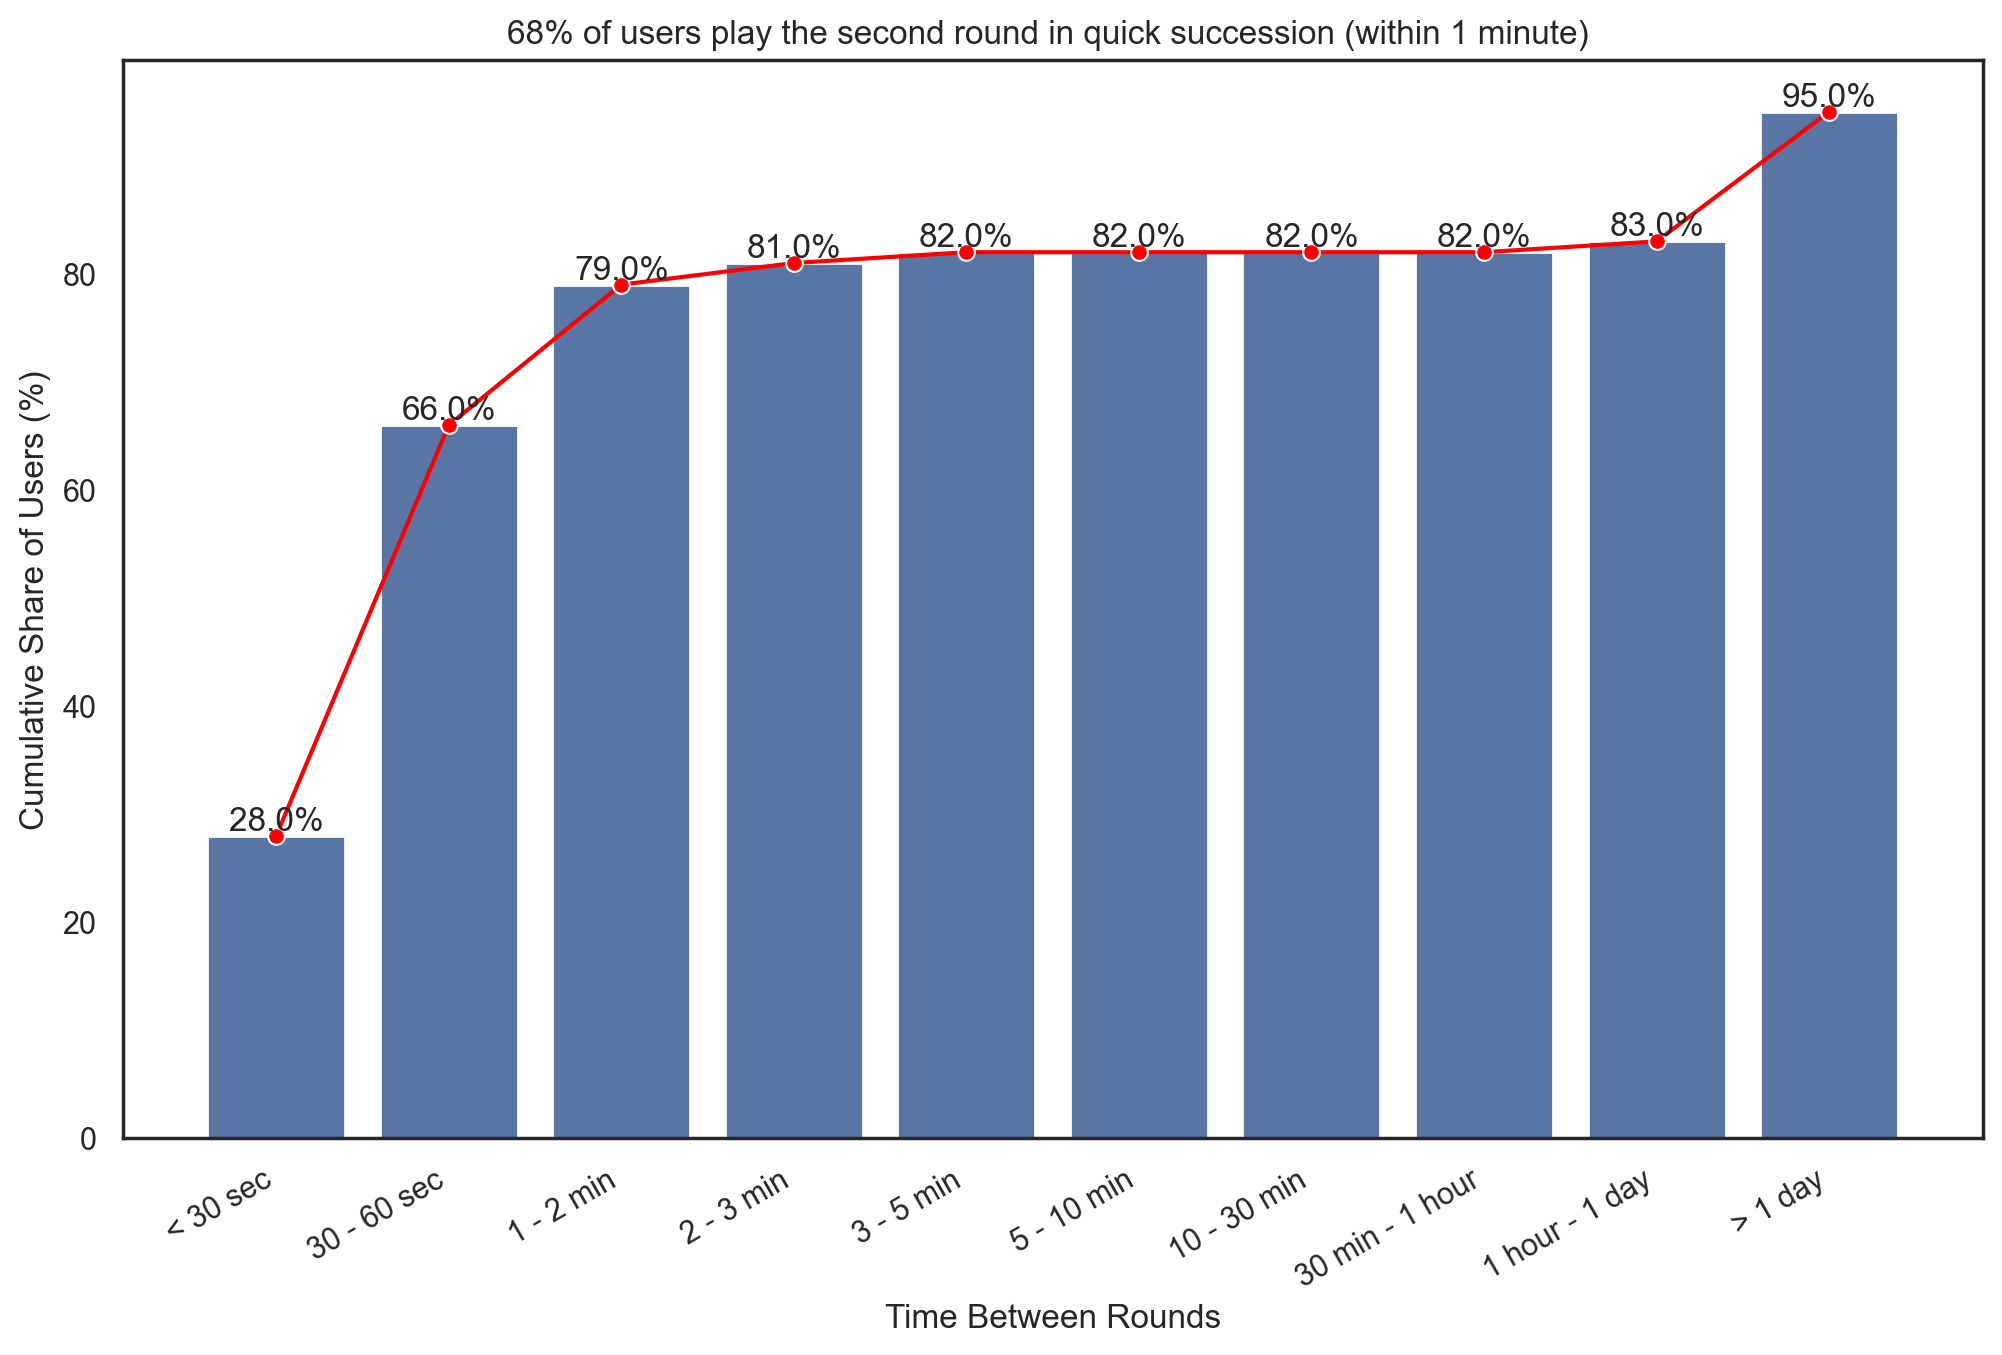

In [259]:
ax = sns.barplot(
    x=dt_bets.index,
    y="cumulative_share",
    data=dt_bets
)
ax.set_title("68% of users play the second round in quick succession (within 1 minute) ")
ax.set_xlabel("Time Between Rounds")
ax.set_ylabel("Cumulative Share of Users (%)")

# Rotate x-axis tick labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# Add labels to the bar plots
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add a line plot on top of the bars
lineplot = sns.lineplot(x=dt_bets.index, y="cumulative_share", data=dt_bets, color='red', marker='o')


In [267]:
second_bet = (
    bets[bets["bet_order"] == 2]
    .groupby(["user_id", "bet_order"])
    .agg(
        {
            "datetime": "min",
        }
    )
    .reset_index()
)

third_bet = (
    bets[bets["bet_order"] == 3]
    .groupby(["user_id", "bet_order"])
    .agg(
        {
            "datetime": "min",
        }
    )
    .reset_index()
)

bets_round_duration = third_bet.merge(second_bet, on="user_id", suffixes=("_3", "_2"), how="inner")
bets_round_duration["duration"] = bets_round_duration["datetime_3"] - bets_round_duration["datetime_2"]
bets_round_duration["minutes_between_rounds"] = bets_round_duration["duration"].dt.total_seconds() / 60
bets_round_duration.head()

bins_edges = [
    0,
    0.5,
    1,
    2,
    3,
    5,
    10,
    30,
    60,
    24 * 60,
    np.inf,
]  # Adjusted bin edges for new intervals
bins_labels = [
    "< 30 sec",
    "30 - 60 sec",
    "1 - 2 min",
    "2 - 3 min",
    "3 - 5 min",
    "5 - 10 min",
    "10 - 30 min",
    "30 min - 1 hour",
    "1 hour - 1 day",
    "> 1 day",
]
bets_round_duration["bins_between_rounds"] = pd.cut(
    bets_round_duration["minutes_between_rounds"], bins=bins_edges, labels=bins_labels
)


# 
# The code is calculating the minimum datetime for
#   the second bet (`"datetime_2": "min"`) 
#    and the maximum datetime for the third bet (`"datetime_3": "max"`) within each bin of time between rounds.
# This is  done to get the range of dates within which the bets in each bin occurred. 
#  The minimum datetime of the second bet gives the earliest date when a bet in that bin was placed,
#  and the maximum datetime of the third bet gives the latest date when a bet in that bin was placed.

# If both were set to min, it would give the earliest date for both the second and third bets, 
# which might not accurately represent the range of dates for the bets in each bin. Similarly, if both were set to max, it would give the latest date for both bets, which might also not accurately represent the range.
# By using min for the second bet and max for the third bet, the code is effectively capturing the full range of dates for the bets in each bin.
dt_bets = bets_round_duration.groupby(["bins_between_rounds"]).agg(
    {
        "user_id": "nunique",
        "datetime_2": "min",
        "datetime_3": "max",
        "duration": "mean",
        "minutes_between_rounds": "mean",
    }
)
dt_bets = dt_bets.rename(columns={"user_id": "unique_users"})
dt_bets["share_of_users"] = (
    dt_bets["unique_users"] / dt_bets["unique_users"].sum() * 100
)
dt_bets["share_of_users"] = dt_bets["share_of_users"].astype(int)
dt_bets['cumulative_share'] = dt_bets['share_of_users'].cumsum()

fig = px.bar(
    dt_bets,
    x=dt_bets.index,
    y="share_of_users",
    title="Distribution of Time Between 2 and 3 Rounds (in Minutes) ", #of users who placed at least 2 bets
    labels={"share_of_users": "Share of Users (%)"},
    text="share_of_users",
)

# Customizing bar colors
fig = fig.update_traces(
    marker_color="RoyalBlue", texttemplate="%{text:f}%", textposition="outside"
)

# Enhancing layout
fig = fig.update_layout(
    plot_bgcolor="white",
    xaxis=dict(title="Time Between Rounds", linecolor="black", showgrid=False),
    yaxis=dict(title="Share of Users (%)", linecolor="black", showgrid=False),
    font=dict(size=12, color="black"),
    margin=dict(l=40, r=40, t=40, b=40),
)

# Show the graph
fig.show()

user_id  bet_order_3                 datetime_3  bet_order_2  \
0       72          3.0 2023-01-28 08:06:42.512629          2.0   
1       73          3.0 2023-07-07 22:24:33.186783          2.0   
2       79          3.0 2023-02-04 12:39:21.146878          2.0   
3       95          3.0 2023-07-24 08:38:56.863005          2.0   
4       97          3.0 2023-07-30 17:19:54.505533          2.0   

                  datetime_2                duration  minutes_between_rounds  
0 2023-01-28 08:06:17.145415  0 days 00:00:25.367214                0.422787  
1 2023-07-07 22:23:56.256065  0 days 00:00:36.930718                0.615512  
2 2023-02-04 12:38:35.639722  0 days 00:00:45.507156                0.758453  
3 2023-06-24 07:28:21.181877 30 days 01:10:35.681128            43270.594685  
4 2023-05-22 05:01:54.606292 69 days 12:17:59.899241           100097.998321

/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_10699/1165842355.py:69: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# Cohorts

## CashGrab

In [269]:
# Create a 'CohortMonth' column by grouping the data and selecting the minimum value in the 'MONTH' column
first_activity_month = df_rentetion.groupby("ACCOUNT_IDT", as_index=False).agg({
    "MONTH": "min"
})

# Rename the 'MONTH' column to 'FirstActivityMonth'
first_activity_month = first_activity_month.rename(columns={"MONTH": "FirstActivityMonth"})

cohort_data = pd.merge(
    df_rentetion, first_activity_month, on="ACCOUNT_IDT", how="left"
)

cohort_data['MONTH'] = pd.to_datetime(cohort_data['MONTH'])
cohort_data['FirstActivityMonth'] = pd.to_datetime(cohort_data['FirstActivityMonth'])

# We then create the 'CohortMonthlyIndex' which indicates the number of months since the first activity
# Note: +1 at the end is to make sure the month in which the first activity occurred is indexed as 1
cohort_data['CohortMonthlyIndex'] = (
    (cohort_data['MONTH'].dt.year - cohort_data['FirstActivityMonth'].dt.year) * 12 +
    (cohort_data['MONTH'].dt.month - cohort_data['FirstActivityMonth'].dt.month) + 1
)

cohort_data.head()

MONTH  ACCOUNT_IDT FirstActivityMonth  CohortMonthlyIndex
0 2023-01-01      5383484         2023-01-01                   1
1 2023-01-01      5383502         2023-01-01                   1
2 2023-01-01      5383524         2023-01-01                   1
3 2023-01-01      5383769         2023-01-01                   1
4 2023-01-01      5383794         2023-01-01                   1

In [270]:
cohort_data['FirstActivityMonth'] = cohort_data['FirstActivityMonth'].dt.strftime('%Y-%m')
cohort_pivot = cohort_data.pivot_table(
    index="FirstActivityMonth",
    columns="CohortMonthlyIndex",
    values="ACCOUNT_IDT",
    aggfunc='nunique',
)

cohort_pivot

CohortMonthlyIndex       1       2       3      4      5      6      7   \
FirstActivityMonth                                                        
2023-01              5206.0  1278.0   736.0  454.0  331.0  289.0  246.0   
2023-02              3710.0  1290.0   496.0  309.0  249.0  206.0  173.0   
2023-03              5373.0  1255.0   524.0  446.0  367.0  299.0  282.0   
2023-04              4641.0  1100.0   701.0  542.0  454.0  421.0  368.0   
2023-05              3568.0  1337.0   823.0  647.0  583.0  473.0  320.0   
2023-06              3754.0  1353.0   811.0  700.0  539.0  366.0  258.0   
2023-07              4628.0  1673.0  1166.0  905.0  549.0  377.0  153.0   
2023-08              5226.0  2432.0  1536.0  846.0  529.0  203.0    NaN   
2023-09              7352.0  2762.0  1119.0  651.0  237.0    NaN    NaN   
2023-10             11105.0  2422.0  1013.0  342.0    NaN    NaN    NaN   
2023-11             11115.0  2089.0   479.0    NaN    NaN    NaN    NaN   
2023-12             13847.0  1758.0     NaN    NaN    NaN    NaN    NaN   
2024-01               651.0     NaN     NaN    NaN    NaN    NaN    NaN   

CohortMonthlyIndex     8      9      10     11     12    13  
FirstActivityMonth                                           
2023-01             226.0  225.0  186.0  168.0  125.0  47.0  
2023-02             160.0  157.0  127.0   86.0   34.0   NaN  
2023-03             257.0  174.0  138.0   52.0    NaN   NaN  
2023-04             269.0  194.0   77.0    NaN    NaN   NaN  
2023-05             245.0   92.0    NaN    NaN    NaN   NaN  
2023-06             106.0    NaN    NaN    NaN    NaN   NaN  
2023-07               NaN    NaN    NaN    NaN    NaN   NaN  
2023-08               NaN    NaN    NaN    NaN    NaN   NaN  
2023-09               NaN    NaN    NaN    NaN    NaN   NaN  
2023-10               NaN    NaN    NaN    NaN    NaN   NaN  
2023-11               NaN    NaN    NaN    NaN    NaN   NaN  
2023-12               NaN    NaN    NaN    NaN    NaN   NaN  
2024-01               NaN    NaN    NaN    NaN    NaN   NaN

In [190]:
cohort_pivot_perc = cohort_pivot.div(cohort_pivot.iloc[:, 0], axis=0) #.round(2) * 100
# cohort_pivot = cohort_pivot.astype(int)
# cohort_pivot = cohort_pivot.fillna(0).astype(int)#.style.background_gradient(cmap='Blues')
cohort_pivot_perc

CohortMonthlyIndex   1         2         3         4         5         6   \
FirstActivityMonth                                                          
2023-01             1.0  0.245486  0.141375  0.087207  0.063580  0.055513   
2023-02             1.0  0.347709  0.133693  0.083288  0.067116  0.055526   
2023-03             1.0  0.233575  0.097525  0.083008  0.068304  0.055649   
2023-04             1.0  0.237018  0.151045  0.116785  0.097824  0.090713   
2023-05             1.0  0.374720  0.230661  0.181334  0.163397  0.132567   
2023-06             1.0  0.360416  0.216036  0.186468  0.143580  0.097496   
2023-07             1.0  0.361495  0.251945  0.195549  0.118626  0.081461   
2023-08             1.0  0.465365  0.293915  0.161883  0.101225  0.038844   
2023-09             1.0  0.375680  0.152203  0.088547  0.032236       NaN   
2023-10             1.0  0.218100  0.091220  0.030797       NaN       NaN   
2023-11             1.0  0.187944  0.043095       NaN       NaN       NaN   
2023-12             1.0  0.126959       NaN       NaN       NaN       NaN   
2024-01             1.0       NaN       NaN       NaN       NaN       NaN   

CohortMonthlyIndex        7         8         9         10        11  \
FirstActivityMonth                                                     
2023-01             0.047253  0.043411  0.043219  0.035728  0.032270   
2023-02             0.046631  0.043127  0.042318  0.034232  0.023181   
2023-03             0.052485  0.047832  0.032384  0.025684  0.009678   
2023-04             0.079293  0.057962  0.041801  0.016591       NaN   
2023-05             0.089686  0.068666  0.025785       NaN       NaN   
2023-06             0.068727  0.028237       NaN       NaN       NaN   
2023-07             0.033060       NaN       NaN       NaN       NaN   
2023-08                  NaN       NaN       NaN       NaN       NaN   
2023-09                  NaN       NaN       NaN       NaN       NaN   
2023-10                  NaN       NaN       NaN       NaN       NaN   
2023-11                  NaN       NaN       NaN       NaN       NaN   
2023-12                  NaN       NaN       NaN       NaN       NaN   
2024-01                  NaN       NaN       NaN       NaN       NaN   

CohortMonthlyIndex        12        13  
FirstActivityMonth                      
2023-01             0.024011  0.009028  
2023-02             0.009164       NaN  
2023-03                  NaN       NaN  
2023-04                  NaN       NaN  
2023-05                  NaN       NaN  
2023-06                  NaN       NaN  
2023-07                  NaN       NaN  
2023-08                  NaN       NaN  
2023-09                  NaN       NaN  
2023-10                  NaN       NaN  
2023-11                  NaN       NaN  
2023-12                  NaN       NaN  
2024-01                  NaN       NaN

Text(0.5, 1.0, 'Cohort Analysis - Retention Rate')

Text(0.5, 87.49999999999997, 'Cohort Monthly Index')

Text(233.49999999999997, 0.5, 'First Activity Month')

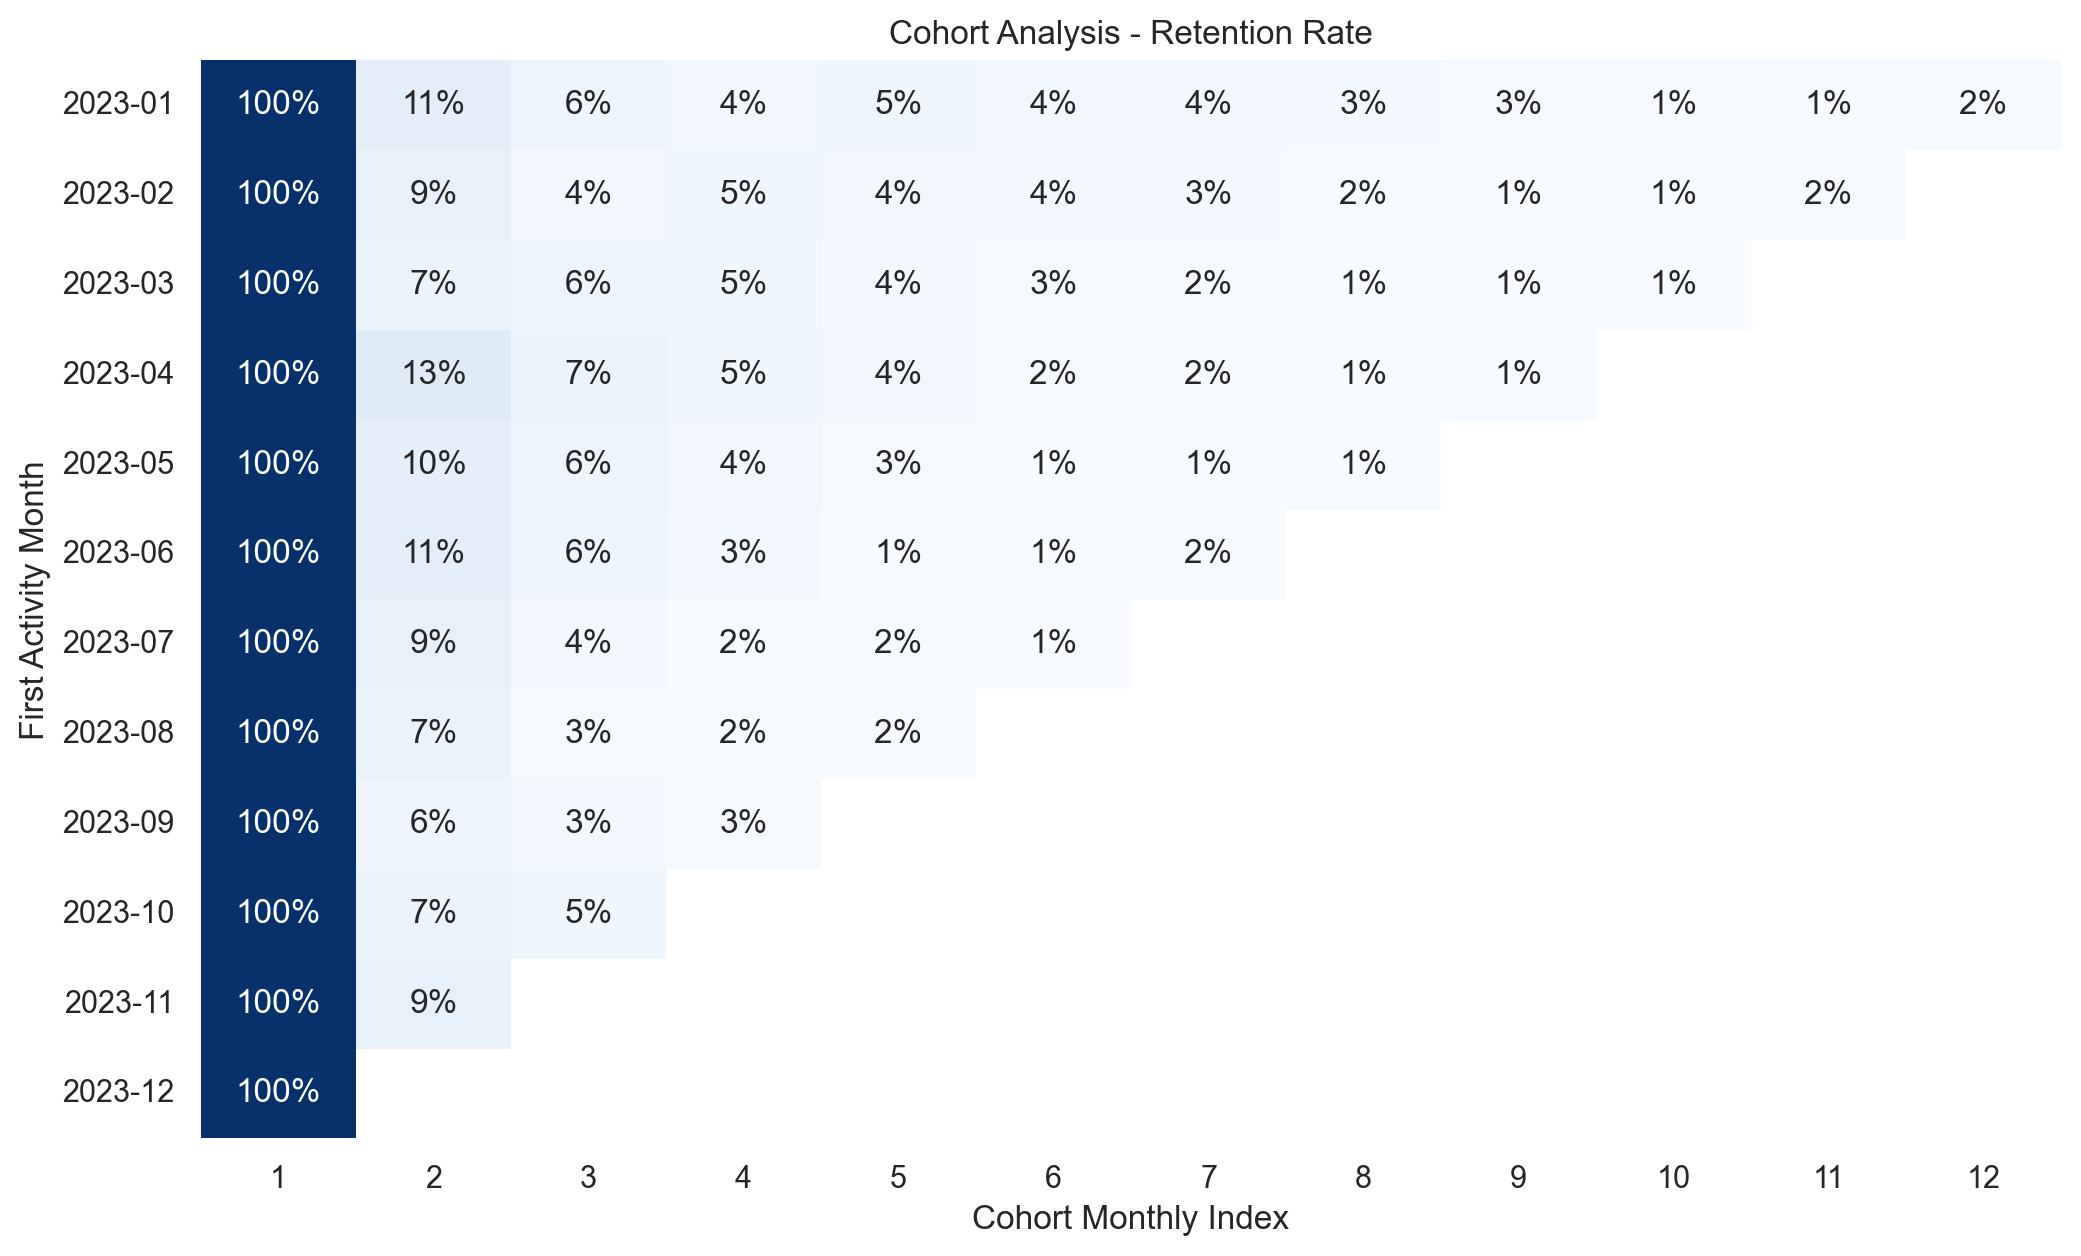

In [271]:
sns.set_theme(style="white")
ax = sns.heatmap(cohort_pivot_perc, annot=True, cmap="Blues", fmt=".0%", cbar=False)

plt.title("Cohort Analysis - Retention Rate")
plt.xlabel("Cohort Monthly Index")
plt.ylabel("First Activity Month")

Text(0.5, 1.0, 'Retention Rate by Month Since First Bet across Cash Grab Players')

Text(0.5, 0, 'Months Since First Bet')

Text(0, 0.5, 'Retention Rate, %')

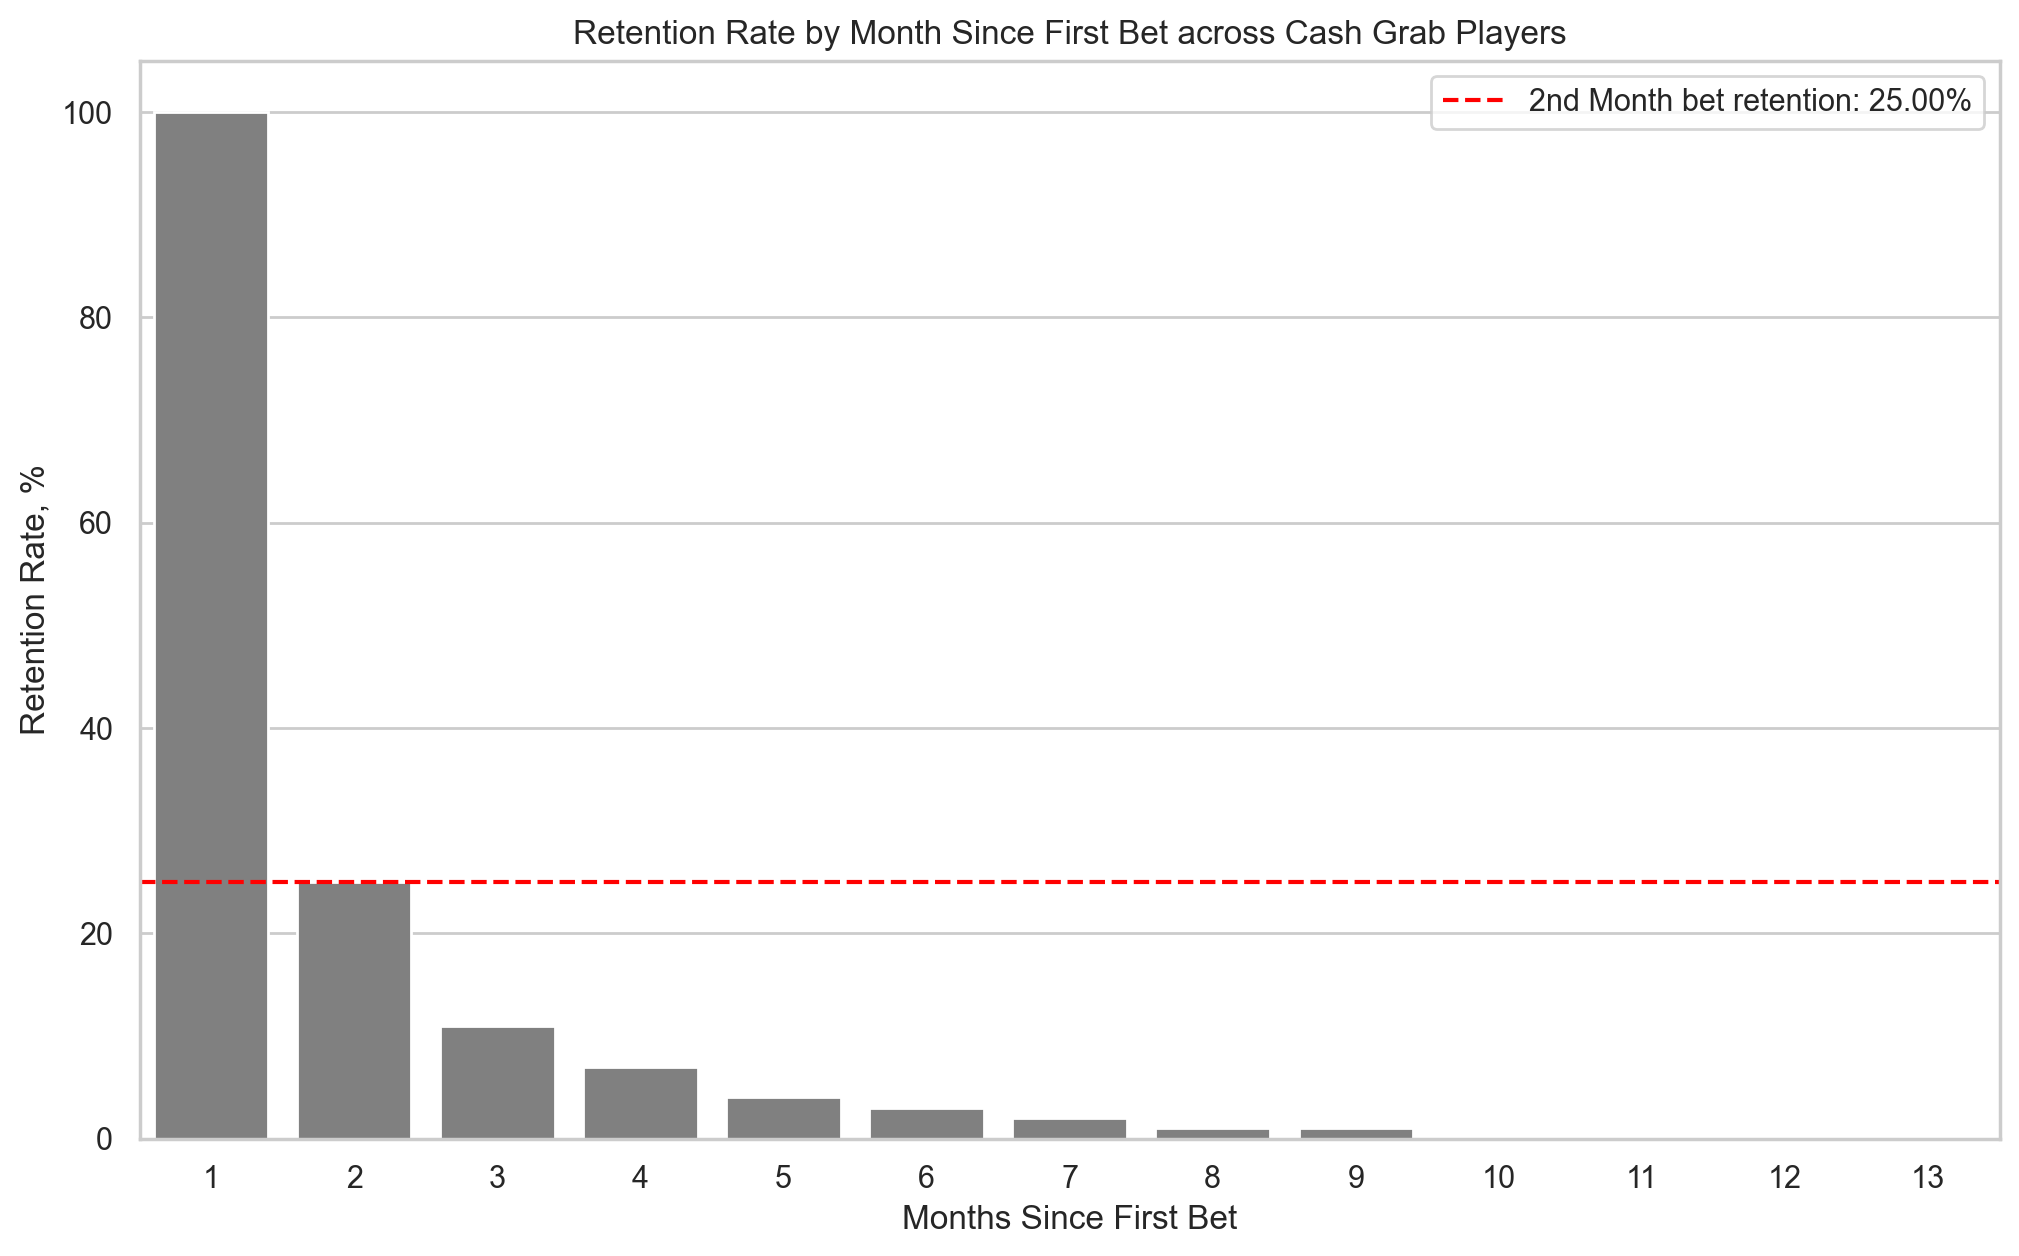

In [272]:
# Create pivot table for cohort analysis
# Calculate retention rate
cohort_sizes = cohort_pivot.iloc[:,0]
# retention = cohort_pivot.divide(cohort_sizes, axis=0)
retention = cohort_pivot.sum(axis=0)
retention = retention / retention.iloc[0]
# retention = retention.mean(axis=0, skipna=True)
retention = (retention*100).astype(int)

sns.set(style="whitegrid")
ax = sns.barplot(x=retention.index, y=retention.values, color='grey')
plt.title('Retention Rate by Month Since First Bet across Cash Grab Players')
plt.xlabel('Months Since First Bet')
plt.ylabel('Retention Rate, %')

# Calculate average retention rate from 2nd to 12th month
avg_retention = retention.iloc[1]#.values[0] #retention.iloc[2:2].mean()

# Add average line and display average value
ax.axhline(y=avg_retention, color='red', linestyle='--', label='2nd Month bet retention: {:.2f}%'.format(avg_retention))

plt.legend()
plt.show()

## Bets (export)

In [274]:
bets['user_id'].nunique()

90928

In [276]:
bets['bet_amount'].describe()

count    505433.000000
mean          2.243953
std           4.598446
min           0.000000
25%           0.000000
50%           0.510000
75%           2.000000
max         113.180000
Name: bet_amount, dtype: float64

: 

In [192]:
# data
first_month_bet = bets.groupby(['user_id']).agg({
    'datetime': 'min'
})
first_month_bet['FirstActivityMonth'] = first_month_bet['datetime'].dt.to_period('M')

# Drop the original datetime column
first_month_bet = first_month_bet.drop(columns=['datetime'])

# Merge the original DataFrame with the first_month_bet DataFrame
cohort_months = bets.merge(first_month_bet, on='user_id')
# Calculate the number of months since the first activity
cohort_months['MonthSinceFirstActivity'] = (
    (cohort_months['datetime'].dt.to_period('M') - cohort_months['FirstActivityMonth']).apply(lambda x: x.n)
) + 1

# Create a pivot table for the monthly cohort analysis
cohort_pivot = cohort_months.pivot_table(
    index='FirstActivityMonth',
    columns='MonthSinceFirstActivity',
    values='user_id',
    aggfunc='nunique',
)

cohort_pivot.head()

MonthSinceFirstActivity      1      2      3      4      5      6      7   \
FirstActivityMonth                                                          
2023-01                  6949.0  774.0  423.0  281.0  356.0  281.0  268.0   
2023-02                  5493.0  480.0  239.0  270.0  225.0  206.0  188.0   
2023-03                  3852.0  267.0  243.0  202.0  146.0  111.0   93.0   
2023-04                  5329.0  695.0  384.0  272.0  215.0  127.0   83.0   
2023-05                  9092.0  954.0  559.0  357.0  238.0  136.0  121.0   

MonthSinceFirstActivity     8      9     10     11     12  
FirstActivityMonth                                         
2023-01                  229.0  184.0  98.0  102.0  117.0  
2023-02                  123.0   65.0  63.0   87.0    NaN  
2023-03                   50.0   50.0  50.0    NaN    NaN  
2023-04                   69.0   69.0   NaN    NaN    NaN  
2023-05                  102.0    NaN   NaN    NaN    NaN

Text(0.5, 1.0, 'Monthly Cohorts: User Retention (Cash Grab Players)')

[Text(0.5, 87.49999999999997, 'Months Since First Activity'),
 Text(233.49999999999997, 0.5, 'First Activity Month')]

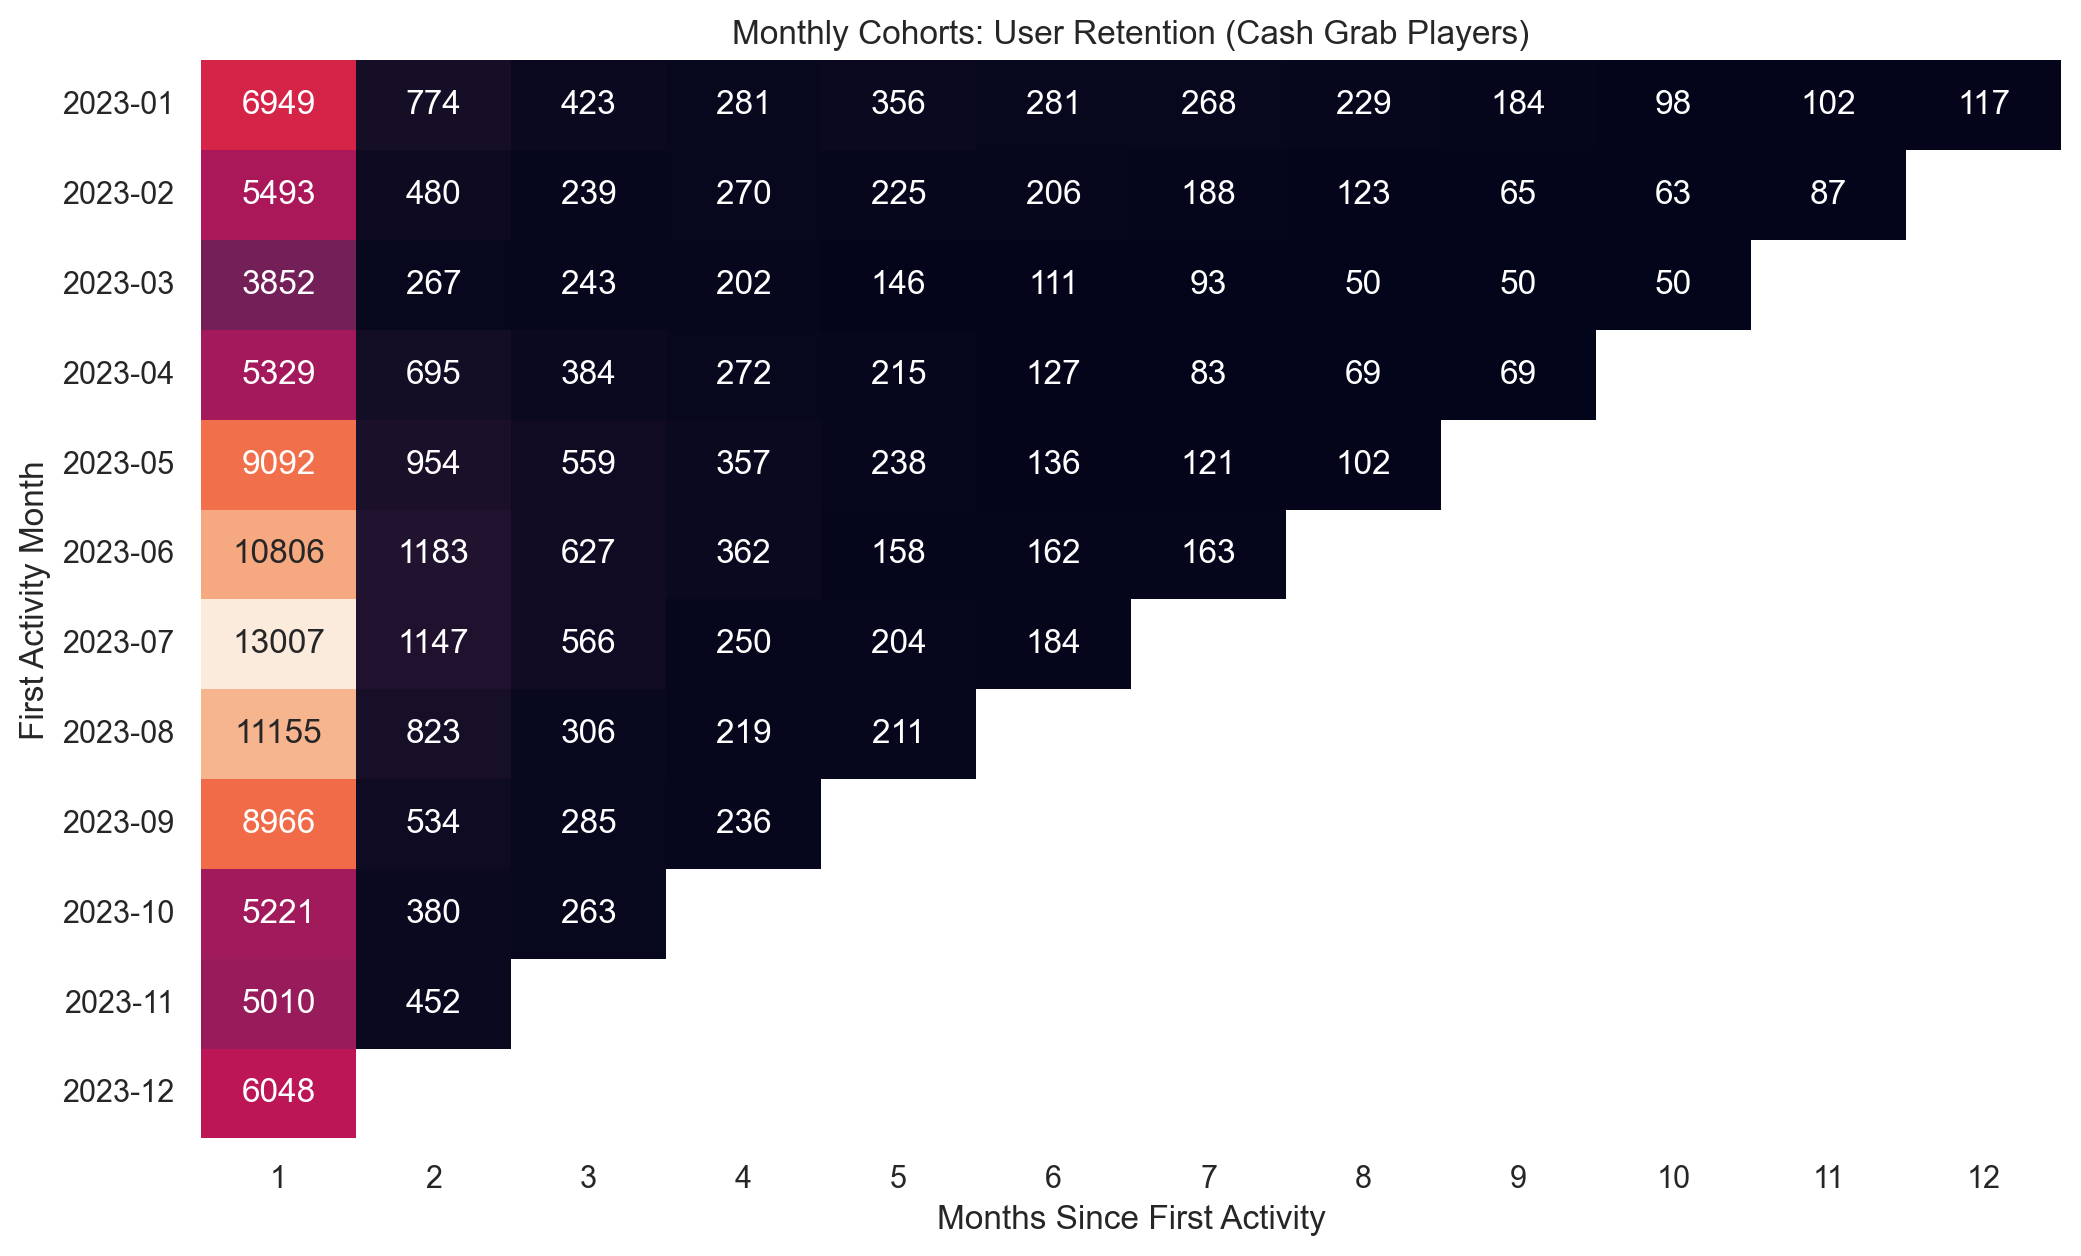

In [194]:
f = sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cbar=False)
f.set_title('Monthly Cohorts: User Retention (Cash Grab Players)')
f.set(xlabel='Months Since First Activity', ylabel='First Activity Month')
plt.show()

In [228]:
cohort_pivot_perc = cohort_pivot.div(cohort_pivot.iloc[:, 0], axis=0) #.round(2) * 100
cohort_pivot_perc

MonthSinceFirstActivity   1         2         3         4         5   \
FirstActivityMonth                                                     
2023-01                  1.0  0.111383  0.060872  0.040437  0.051230   
2023-02                  1.0  0.087384  0.043510  0.049153  0.040961   
2023-03                  1.0  0.069315  0.063084  0.052440  0.037902   
2023-04                  1.0  0.130418  0.072059  0.051041  0.040345   
2023-05                  1.0  0.104927  0.061483  0.039265  0.026177   
2023-06                  1.0  0.109476  0.058023  0.033500  0.014622   
2023-07                  1.0  0.088183  0.043515  0.019220  0.015684   
2023-08                  1.0  0.073779  0.027432  0.019632  0.018915   
2023-09                  1.0  0.059558  0.031787  0.026322       NaN   
2023-10                  1.0  0.072783  0.050373       NaN       NaN   
2023-11                  1.0  0.090220       NaN       NaN       NaN   
2023-12                  1.0       NaN       NaN       NaN       NaN   

MonthSinceFirstActivity        6         7         8         9         10  \
FirstActivityMonth                                                          
2023-01                  0.040437  0.038567  0.032954  0.026479  0.014103   
2023-02                  0.037502  0.034225  0.022392  0.011833  0.011469   
2023-03                  0.028816  0.024143  0.012980  0.012980  0.012980   
2023-04                  0.023832  0.015575  0.012948  0.012948       NaN   
2023-05                  0.014958  0.013308  0.011219       NaN       NaN   
2023-06                  0.014992  0.015084       NaN       NaN       NaN   
2023-07                  0.014146       NaN       NaN       NaN       NaN   
2023-08                       NaN       NaN       NaN       NaN       NaN   
2023-09                       NaN       NaN       NaN       NaN       NaN   
2023-10                       NaN       NaN       NaN       NaN       NaN   
2023-11                       NaN       NaN       NaN       NaN       NaN   
2023-12                       NaN       NaN       NaN       NaN       NaN   

MonthSinceFirstActivity        11        12  
FirstActivityMonth                           
2023-01                  0.014678  0.016837  
2023-02                  0.015838       NaN  
2023-03                       NaN       NaN  
2023-04                       NaN       NaN  
2023-05                       NaN       NaN  
2023-06                       NaN       NaN  
2023-07                       NaN       NaN  
2023-08                       NaN       NaN  
2023-09                       NaN       NaN  
2023-10                       NaN       NaN  
2023-11                       NaN       NaN  
2023-12                       NaN       NaN

Text(0.5, 1.0, 'Monthly Cohorts: User Retention (only Cash Grab Players)')

[Text(0.5, 87.49999999999997, 'Months Since First Activity'),
 Text(233.49999999999997, 0.5, 'First Activity Month')]

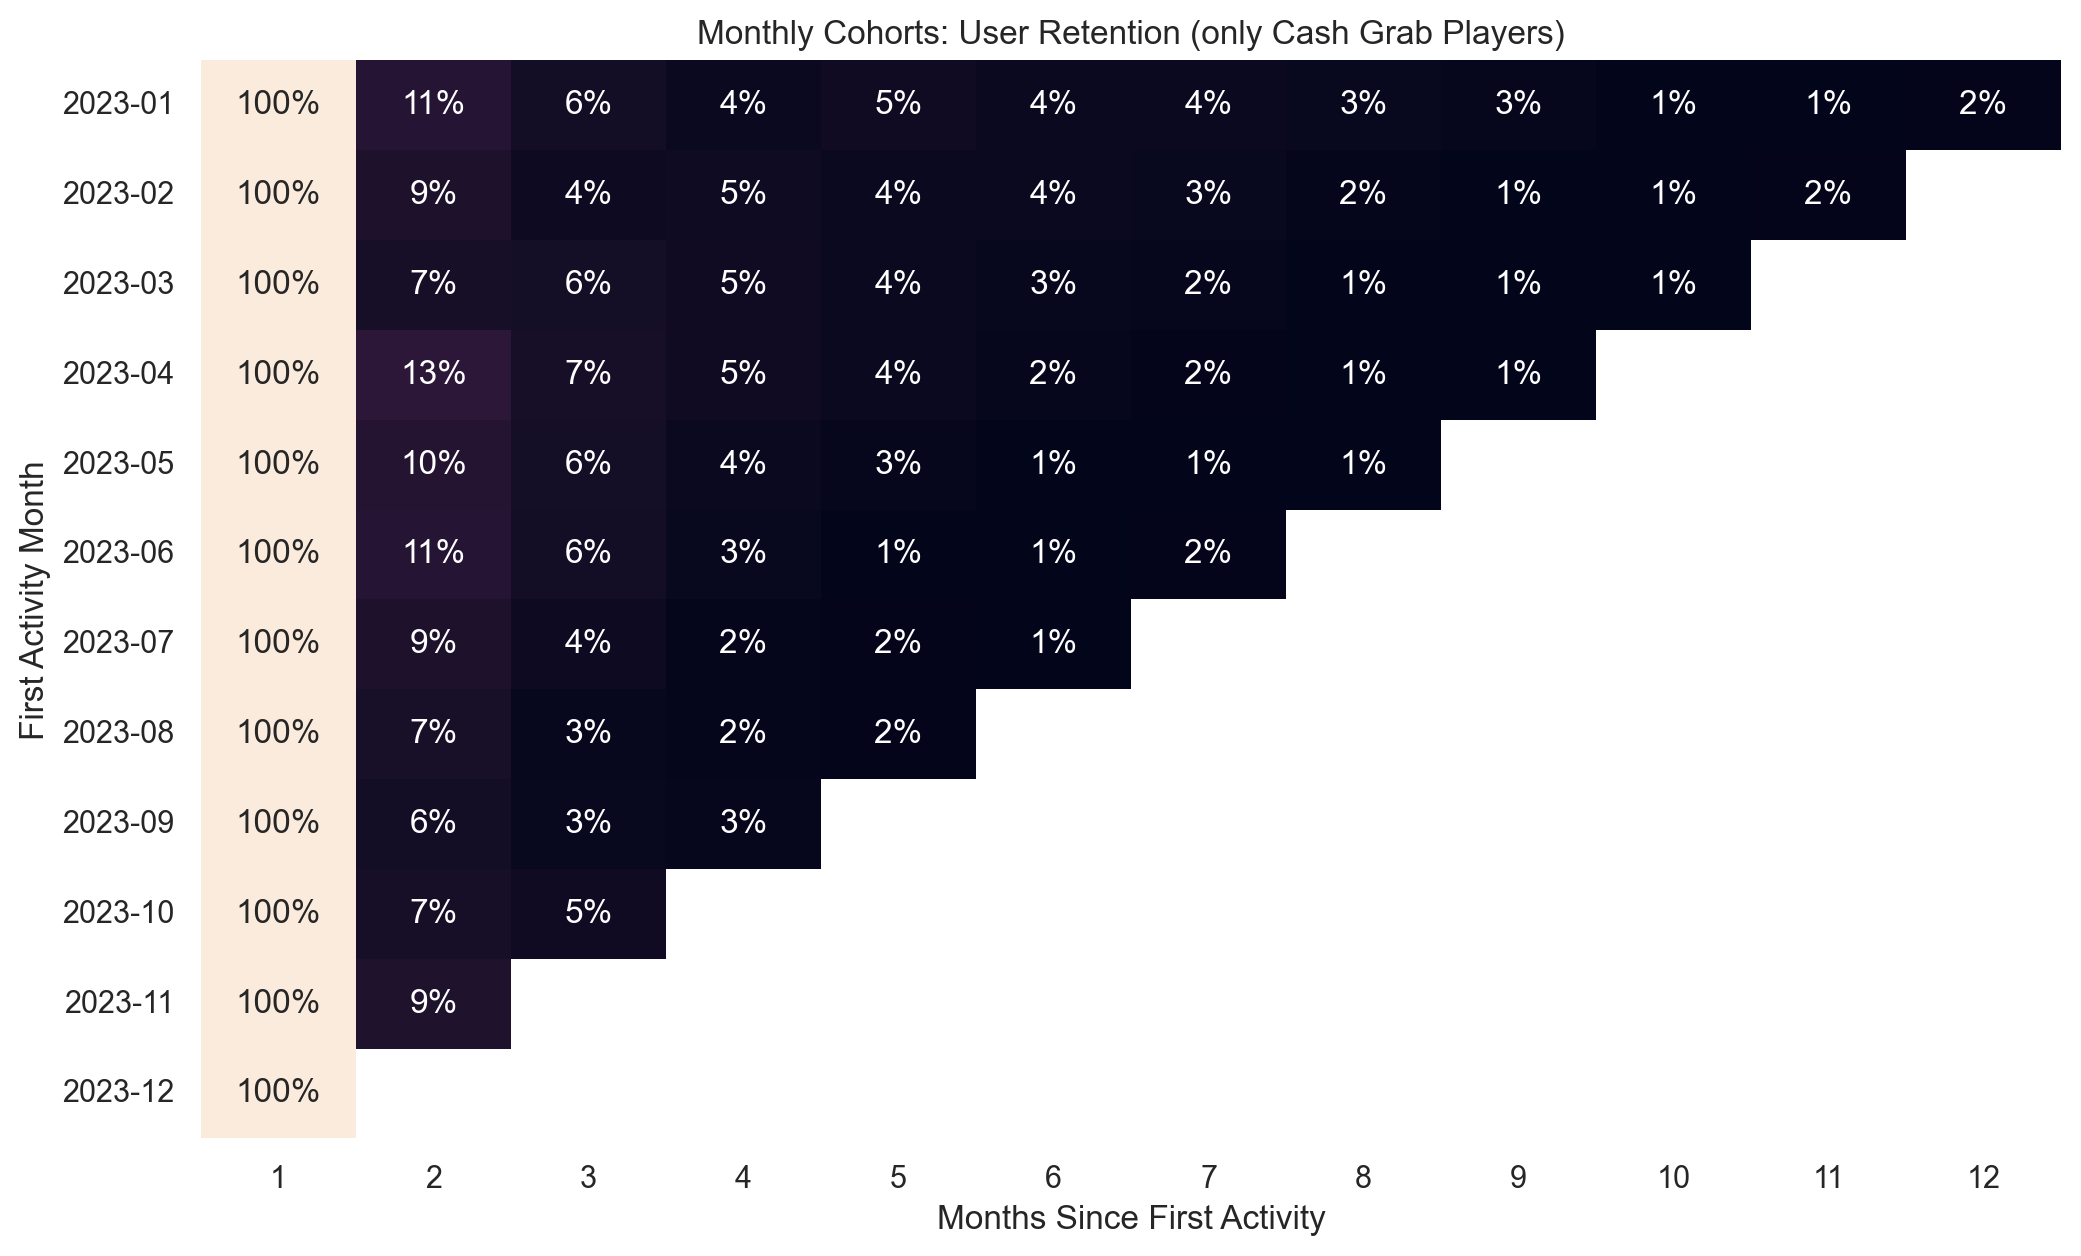

In [255]:
sns.set_theme(style="white")
f = sns.heatmap(cohort_pivot_perc, annot=True, fmt='.0%',cbar=False)
f.set_title('Monthly Cohorts: User Retention (only Cash Grab Players)')
f.set(xlabel='Months Since First Activity', ylabel='First Activity Month')
plt.show()

In [232]:
# f = sns.heatmap(cohort_pivot_perc.iloc[:, 1:], annot=True, fmt='.0%', cbar=False, cmap="Blues")
# f.set_title('Monthly Cohorts: User Retention (only Cash Grab Players)')
# f.set(xlabel='Months Since First Activity', ylabel='First Activity Month')
# plt.show()

# Create a boolean mask where the first column is True
mask = np.zeros_like(cohort_pivot_perc)
mask[:, 0] = True

f = sns.heatmap(cohort_pivot_perc, annot=True, fmt='.0%', cbar=False, mask=mask)
f.set_title('Monthly Cohorts: User Retention (only Cash Grab Players)')
f.set(xlabel='Months Since First Activity', ylabel='First Activity Month')
plt.show()

Text(0.5, 1.0, 'Monthly Cohorts: User Retention (only Cash Grab Players)')

[Text(0.5, 87.49999999999997, 'Months Since First Activity'),
 Text(233.49999999999997, 0.5, 'First Activity Month')]

Text(0.5, 1.0, 'Retention Rate by Month Since First Bet across Cash Grab Players')

Text(0.5, 0, 'Months Since First Bet')

Text(0, 0.5, 'Retention Rate, %')

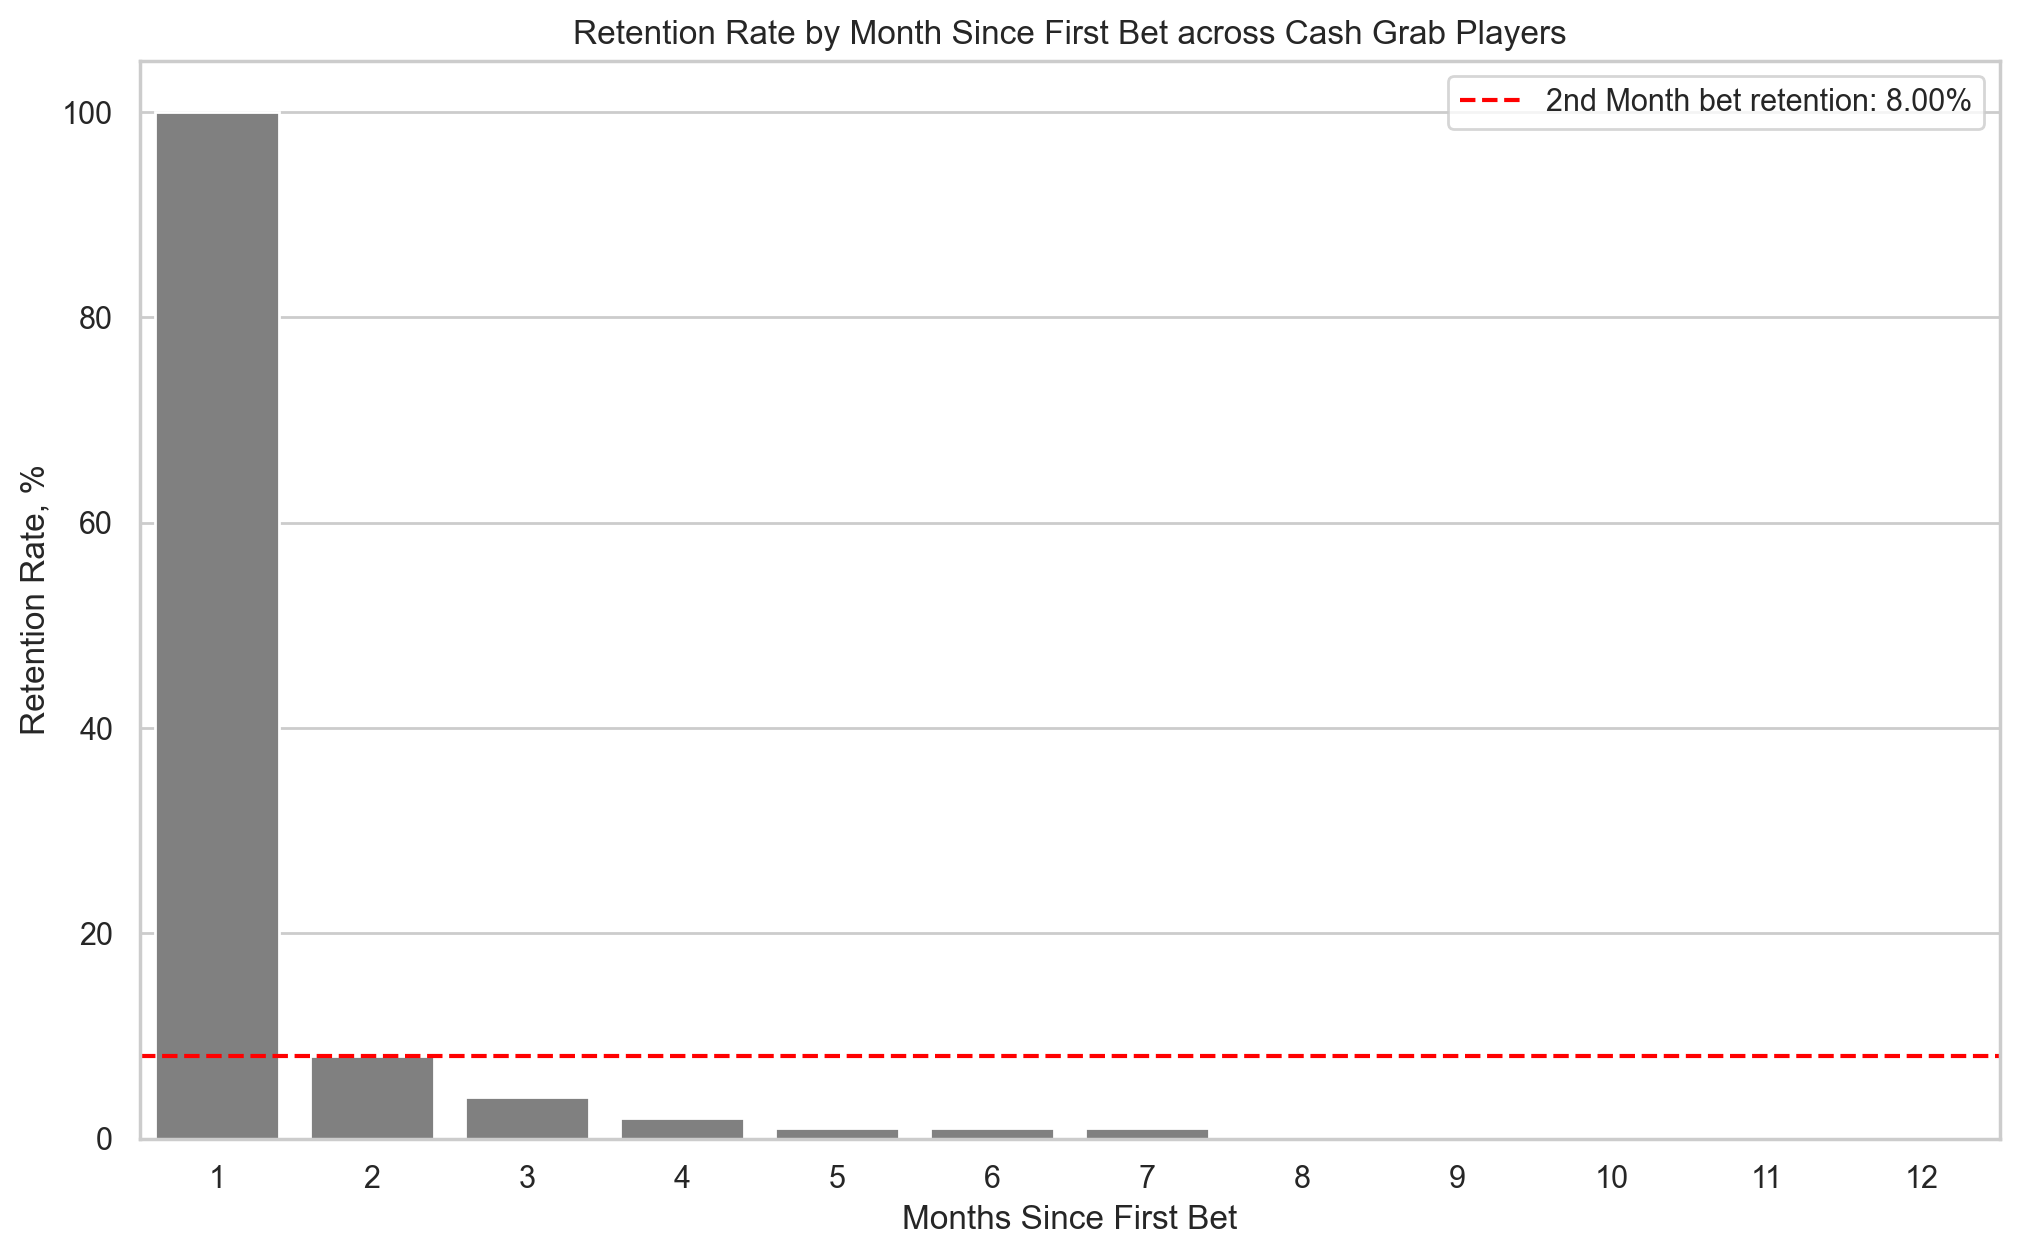

In [254]:
# Create pivot table for cohort analysis
# Calculate retention rate
cohort_sizes = cohort_pivot.iloc[:,0]
# retention = cohort_pivot.divide(cohort_sizes, axis=0)
retention = cohort_pivot.sum(axis=0)
retention = retention / retention.iloc[0]
# retention = retention.mean(axis=0, skipna=True)
retention = (retention*100).astype(int)

sns.set(style="whitegrid")
ax = sns.barplot(x=retention.index, y=retention.values, color='grey')
plt.title('Retention Rate by Month Since First Bet across Cash Grab Players')
plt.xlabel('Months Since First Bet')
plt.ylabel('Retention Rate, %')

# Calculate average retention rate from 2nd to 12th month
avg_retention = retention.iloc[1]#.values[0] #retention.iloc[2:2].mean()

# Add average line and display average value
ax.axhline(y=avg_retention, color='red', linestyle='--', label='2nd Month bet retention: {:.2f}%'.format(avg_retention))

plt.legend()
plt.show()

# Share

# Appendix

In [ ]:
q = """
WITH crab_users AS (
    SELECT
        cb.account_idt,
        MIN(cb.date) AS first_time
    FROM DWH_DB.dwh.fact_casino_bets cb
    INNER JOIN DWH_DB.dwh.dim_game g
        ON g.game_idt = cb.game_idt
    WHERE game_name = 'Cash Crab'
    GROUP BY cb.account_idt
),
cohort_data AS (
    SELECT
        cu.account_idt,
        CAST(DATE_TRUNC('month', cb.date) AS DATE) AS month,
        CAST(DATE_TRUNC('month', cu.first_time) AS DATE) AS FirstActivityMonth,
        DATEDIFF(month, cu.first_time, cb.date) + 1 AS CohortIndex
    FROM crab_users cu
    INNER JOIN DWH_DB.dwh.fact_casino_bets cb
        ON cu.account_idt = cb.account_idt
        AND cu.first_time <= cb.date  -- Change this line
    INNER JOIN DWH_DB.dwh.dim_customers c
        ON c.account_idt = cu.account_idt
    WHERE c.type IN ('casino', 'sport')
        AND YEAR(c.CREATED) = 2023
),
cohort_counts AS (
    SELECT
        TO_CHAR(FirstActivityMonth, 'YYYY-MM') AS FirstActivityMonth,
        CohortIndex,
        COUNT(DISTINCT account_idt) AS n_users
    FROM cohort_data
    GROUP BY FirstActivityMonth, CohortIndex
)
SELECT
    FirstActivityMonth,
    MAX(CASE WHEN CohortIndex = 1 THEN n_users END) AS "1m",
    MAX(CASE WHEN CohortIndex = 2 THEN n_users END) AS "2m",
    MAX(CASE WHEN CohortIndex = 3 THEN n_users END) AS "3m",
    MAX(CASE WHEN CohortIndex = 4 THEN n_users END) AS "4m",
    MAX(CASE WHEN CohortIndex = 5 THEN n_users END) AS "5m",
    MAX(CASE WHEN CohortIndex = 6 THEN n_users END) AS "6m",
    MAX(CASE WHEN CohortIndex = 7 THEN n_users END) AS "7m",
    MAX(CASE WHEN CohortIndex = 8 THEN n_users END) AS "8m",
    MAX(CASE WHEN CohortIndex = 9 THEN n_users END) AS "9m",
    MAX(CASE WHEN CohortIndex = 10 THEN n_users END) AS "10m",
    MAX(CASE WHEN CohortIndex = 11 THEN n_users END) AS "11m",
    MAX(CASE WHEN CohortIndex = 12 THEN n_users END) AS "12m"
FROM cohort_counts
GROUP BY FirstActivityMonth
ORDER BY FirstActivityMonth
;
"""
dt_verification = pd.read_sql(q, connection)
dt_verification.head()

dt = dt_verification.set_index("FIRSTACTIVITYMONTH")
dt = dt.div(dt.iloc[:, 0], axis=0) #.round(2) * 100
dt